### 1.- Download and load the Random Forest model.

In [1]:
# This connection is blocked on the DEA Sandbox, so needs to be downloaded locally and uploaded to Sandbox manually
#!wget https://drive.google.com/file/d/1jfEEYh6wH25tW0InGPgx8aMXt8Cg-dUh/view?usp=sharing

!pip3 install pickle5
import pickle5 as pickle

with open('rf_fmc.pickle', 'rb') as handle:
    rf = pickle.load(handle)
    print(rf)

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
RandomForestRegressor(max_depth=25, n_estimators=25, n_jobs=8)


/env/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### 2.- Load DEA data for Namadgi region

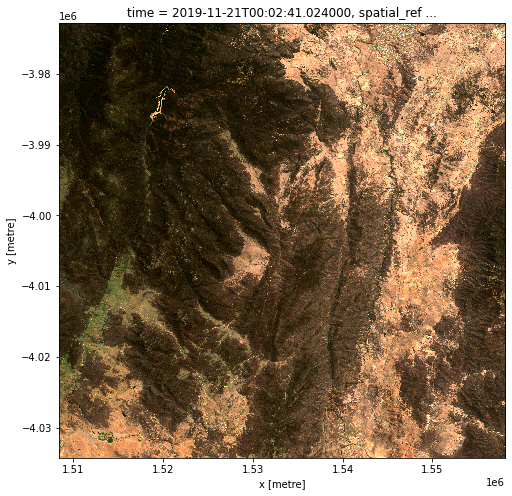

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import datacube
import xarray as xr

dc = datacube.Datacube(app='fmc')

query = {
        'y': (-3972822.7900266224, -4034237.9891385734),
        'x': (1508424.0286794726, 1558083.9107398288),
        'crs': 'EPSG:3577',
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time': ('2019-11-20', '2019-11-22'),
        'measurements': ["nbar_blue","nbar_green","nbar_red",
                         "nbart_red_edge_1","nbart_red_edge_2","nbart_red_edge_3",
                         "nbar_nir_1","nbar_nir_2",
                         "nbar_swir_2","nbar_swir_3"],}

ds = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

ds = ds.isel(time=0)

ds[['nbar_red', 'nbar_green', 'nbar_blue']].to_array().plot.imshow(robust=True, figsize=(8,8))

### 3.- Add NDVI and NDII normalised indices to the dataset

In [3]:
ds['ndvi']=((ds.nbar_nir_1-ds.nbar_red)/(ds.nbar_nir_1+ds.nbar_red))
ds['ndii']=((ds.nbar_nir_1-ds.nbar_swir_2)/(ds.nbar_nir_1+ds.nbar_swir_2))

### 4.- Stack and reshape dataset to be compatible with the RF input

In [4]:
refl = ds[['ndvi','ndii','nbar_red','nbar_green','nbar_blue','nbar_nir_1','nbar_nir_2','nbar_swir_2','nbar_swir_3']].to_array().values
refl_rf = refl.reshape((9,-1)).swapaxes(0,1)

### 5.- Estimate FMC values using RF model and previous reflectance input

In [5]:
rf_fmc = rf.predict(refl_rf)

fmc = rf_fmc.reshape(refl.shape[1:])

### 6.- Create colormap consistent with the current Australian Fuel Monitoring System

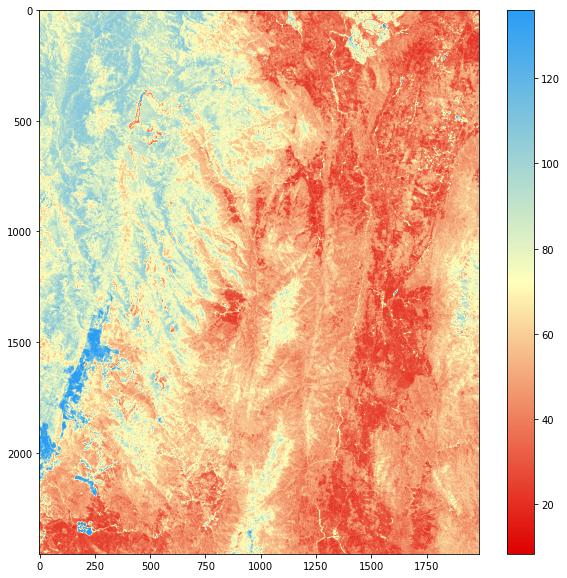

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = [(0.87, 0, 0), (1, 1, 0.73), (0.165, 0.615, 0.957)]  # R -> G -> B
cmap = LinearSegmentedColormap.from_list('fmc', colors, N=256)
plt.figure(figsize=(10,10))
plt.imshow(np.clip(fmc, 0, 136), cmap=cmap)
plt.colorbar()